In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import utils
from ImageMatcher import ImageMatcher, ImagePair
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from glob import glob
import os

In [30]:
DATA_DIR = '/Users/richard/Desktop/Motorized-Dataset/'
TRAJ_DIR = DATA_DIR

in_vid_paths = sorted(glob(DATA_DIR + '*.mp4'))

in_vid_path = in_vid_paths[26]
in_vid_stem = Path(in_vid_path).stem

frames = utils.load_video(in_vid_path,
                          grayscale=True)
masks = np.load(DATA_DIR + in_vid_stem + '-masks.npz')['masks']
video_width = frames[0].shape[1]

print('Using video:', in_vid_stem)
print('n_frames:', len(frames))

Using video: t026-v05
n_frames: 900


In [31]:
kf_interval = 30
matcher = ImageMatcher(frames, human_masks=masks, keyframe_interval=kf_interval)

In [ ]:
#idx = 662
#plt.imshow(frames[idx], 'gray')
#plt.imshow(matcher.human_masks[idx], alpha=0.5, cmap='jet')
#plt.show()

#p = matcher.match(662, 663, 'orb',
#                    min_match_count=25)
#print(np.mean(matcher.human_masks[idx]))
#print(f'Number of matches: {len(p.src_pts)}')
#utils.visualize_matches(p)

In [32]:
img_pairs_path = DATA_DIR + in_vid_stem + '-pairs.h5'
image_pairs = []
closures = []
still_cnt = 0

if os.path.isfile(img_pairs_path):
    print('Loading existing file', img_pairs_path)
    image_pairs = utils.import_image_pairs(img_pairs_path, frames)
    for p in image_pairs:
        if p.still:
            still_cnt += 1
        if p.i != p.j - 1:
            closures.append(p)
else:
    for i in range(0, len(frames) - kf_interval, kf_interval):
        for j in range(i + kf_interval, len(frames), kf_interval):
            if matcher.sift_kds[i] is None or matcher.sift_kds[j] is None:
                continue
            p = matcher.match(i, j, 'sift',
                            min_match_count=25)
            if p is None:
                continue
            closures.append(p)
            image_pairs.append(p)

    for i in range(0, len(frames) - 1):
        p = matcher.match(
            i, i+1,
            min_match_count=60,
            ransac_max_iters=2000,
            #keep_percent=0.5,
            verbose=True,
        )
        if p is None:
            print('No match found for frames', i, i+1)
        image_pairs.append(p)

print('Number of loop closures:', len(closures))

print('Total number of image pairs:', len(image_pairs))

print('Number of still pairs:', still_cnt)

if not os.path.isfile(img_pairs_path):
    utils.export_image_pairs(img_pairs_path, image_pairs)

Number of loop closures: 56
Total number of image pairs: 955
Number of still pairs: 0


In [ ]:
for p in closures:
    print(f'Number of matches from {p.i} to {p.j}: {len(p.src_pts)}')
    utils.visualize_matches(p)

In [61]:
opt_cmd = [
    '../Ceres/build/estimate', DATA_DIR, in_vid_stem + '-pairs.h5',
    'yes',  # enable loop closures
    'no',  # load existing camera params
    'yes',  # use_stills
]
ret = subprocess.run(opt_cmd)
if ret.returncode != 0:
    print(f'Ceres exited with non-zero return code!')

Enabling loop closure constraints.
Optimizing poses for t026-v05.
Loaded 955 image pairs.
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  4.813712e+09    0.00e+00    9.65e+09   0.00e+00   0.00e+00  1.00e+04        0    1.62e-01    3.05e-01
   1  4.943168e+07    4.76e+09    6.38e+08   0.00e+00   9.91e-01  3.00e+04        1    2.86e-01    5.91e-01
   2  1.339121e+08   -8.45e+07    6.38e+08   6.84e+03  -1.73e+00  1.50e+04        1    5.62e-02    6.47e-01
   3  7.610049e+07   -2.67e+07    6.38e+08   5.82e+03  -5.48e-01  3.75e+03        1    5.14e-02    6.98e-01
   4  9.431790e+06    4.00e+07    2.60e+08   3.48e+03   8.39e-01  5.44e+03        1    2.09e-01    9.07e-01
   5  1.542634e+06    7.89e+06    1.10e+08   2.07e+03   8.81e-01  9.76e+03        1    2.23e-01    1.13e+00
   6  3.035821e+05    1.24e+06    8.38e+06   1.67e+03   1.00e+00  2.93e+04        1    2.21e-01    1.35e+00
   7  2.749081e+05    2.87e+04    1.67e+05   1

angular error mean: 0.54833, max: 4.06477
hfov error mean: 0.70039, max: 4.94961


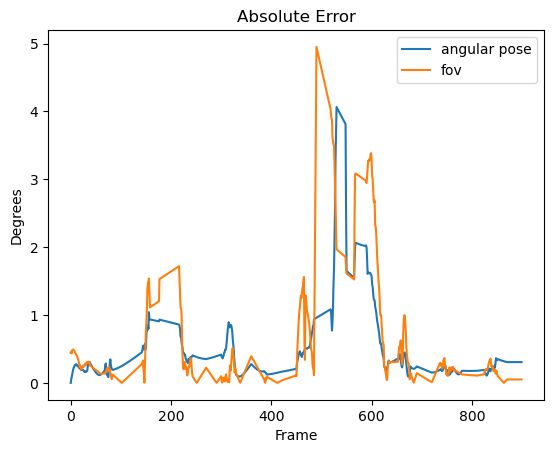

In [62]:
cpe, cpg = utils.load_est_gt_poses(
    in_vid_path, video_width)

cam_params_est, cam_params_gt = utils.set_ref_cam(0, cpe, cpg)

# Compute the angular pose error and hfov error between cam_params and cam_params_gt
angular_err_abs = []
angular_err_rel = []
hfov_err_abs = []
hfov_err_rel = []
cam_indices = []

for i in sorted(cam_params_est.keys()):
    R = cam_params_est[i]['R']
    R_gt = cam_params_gt[i]['R']

    ae = np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude())
    angular_err_abs.append(ae)
    angular_err_rel.append(ae / max(np.degrees(Rot.from_matrix(R_gt.T).magnitude()), 0.1))

    hfove = np.abs(cam_params_est[i]['hfov'] - cam_params_gt[i]['hfov'])
    hfov_err_abs.append(hfove)
    hfov_err_rel.append(hfove / cam_params_gt[i]['hfov'])
    cam_indices.append(i)

print(f'angular error mean: {np.mean(angular_err_abs):.5f}, '
      f'max: {np.max(angular_err_abs):.5f}')
print(f'hfov error mean: {np.mean(hfov_err_abs):.5f}, max: {np.max(hfov_err_abs):.5f}')

plt.title('Absolute Error')
plt.plot(angular_err_abs, label='angular pose')
plt.plot(hfov_err_abs, label='fov')
plt.xlabel('Frame')
plt.ylabel('Degrees')
plt.legend()
plt.show()

In [23]:
angular_err_abs[675]

4.834092408407217

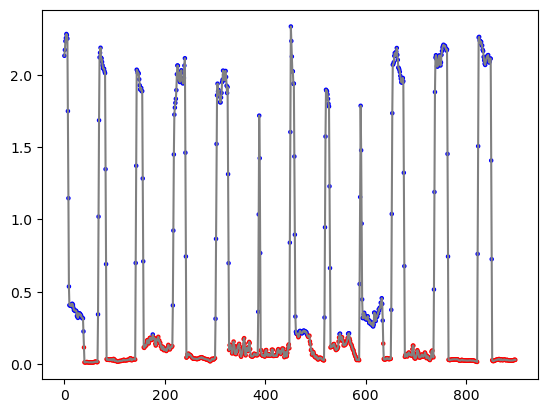

In [59]:
idx2pair = {}
for p in image_pairs:
    idx2pair[(p.i, p.j)] = p

av = []
for i in range(0, len(frames) - 1):
    p = idx2pair[(i, i+1)]
    av.append(utils.avg_quad_angular_velocity(p, cam_params_est[i]))

# Moving average filter to smooth out the angular velocity
# preserve the length of the array (padding = same as edge)
av.insert(0, av[0])
av.append(av[-1])
av = np.convolve(av, np.ones(3) / 3, mode='valid')

still_thresh = 0.2
plt.plot(av, color='gray')
plt.scatter(np.arange(0, len(av)), av, c=['red' if a < still_thresh
                                          else 'blue' for a in av], s=5)
plt.show()

In [60]:
cnt = 0
for i in range(0, len(av)):
    p = idx2pair[(i, i+1)]
    p.still = av[i] < still_thresh
    if p.still:
        cnt += 1
print(f'Number of still pairs: {cnt}')

utils.export_image_pairs(img_pairs_path, image_pairs)

Number of still pairs: 585
